# Analysis of sequential DNA-MERFISH for CTP07

by Pu Zheng

2022.05.30

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_7\20220528-CTP07chr2_hSTG


In [13]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

8396


# 0. fov parameters

In [9]:
fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_7\20220528-CTP07chr2_hSTG',
             'save_folder':r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG',
             'experiment_type': 'DNA',
             'num_threads': 8,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':5,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

# Process DAPI image

In [10]:
# cellpose segmentation
from cellpose import models
# dialation
from scipy import ndimage
from skimage import morphology

In [12]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]
print(len(save_fov_ids))
# segmentation folder
segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")
    
# parameters
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

129
Use segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation


In [15]:
print(segmentation_folder)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation


In [16]:
# Segmentation
for _filename in save_filenames:
    
    # Check savename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_filename).replace('.hdf5', '_Segmentation.npy') )
    if os.path.exists(_segmentation_savefile):
        print(f"Segmentation file: {_segmentation_savefile} already exists, skip.")
        continue
    else:
        print(f"Processing segmentation for: {os.path.basename(_filename)}")
        # Load DAPI
        with h5py.File(_filename, 'r') as _f:
            dna_dapi = _f.attrs['dapi_im'] 
        
        break
        # Create model class
        seg_model = models.CellposeModel(gpu=True, model_type='nuclei') # create model
        # run cellpose
        _seg_start = time.time()
        print(f"- run cellpose segmentation", end=' ')
        labels3d, flows3d, _ = seg_model.eval(
            dna_dapi[:,:,:,np.newaxis], 
            batch_size=60, 
            anisotropy=pixel_sizes[0]/pixel_sizes[1],
            cellprob_threshold=0, 
            channels=[0,0], 
            diameter=60, 
            min_size=100,
            do_3D=True,
            )
        print(f"in {time.time()-_seg_start:.2f}s. ")
        # dialate to smooth contour
        final_labels = ndimage.grey_dilation(labels3d, structure=morphology.ball(1))
        # save
        print(f"- save final labels into file: {_segmentation_savefile}")
        np.save(_segmentation_savefile.split('.npy')[0], final_labels)

Segmentation file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation\Conv_zscan_000_Segmentation.npy already exists, skip.
Segmentation file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation\Conv_zscan_001_Segmentation.npy already exists, skip.
Segmentation file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation\Conv_zscan_002_Segmentation.npy already exists, skip.
Segmentation file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation\Conv_zscan_003_Segmentation.npy already exists, skip.
Segmentation file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation\Conv_zscan_004_Segmentation.npy already exists, skip.
Segmentation file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220528-CTP07chr2_hSTG\Segmentation\Conv_zscan_005_Segmentation.npy already exists, skip.
Segmentation file: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data

## Manually check results

In [64]:
test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in dna_dapi])


In [85]:
# Create model class
seg_model = models.CellposeModel(gpu=True, model_type='nuclei') # create model
# run cellpose
_seg_start = time.time()
print(f"- run cellpose segmentation", end=' ')
labels3d, flows3d, _ = seg_model.eval(
    test_dapi_im[:,:,:,np.newaxis], 
    batch_size=60, 
    anisotropy=pixel_sizes[0]/pixel_sizes[1]/2,
    cellprob_threshold=0,
    invert=False,
    channels=[0,0], #diameter=30, 
    min_size=100,
    do_3D=True,
    )
print(f"in {time.time()-_seg_start:.2f}s. ")

- run cellpose segmentation in 56.81s. 


In [84]:
seg_model.eval?

<IPython.core.display.Javascript object>


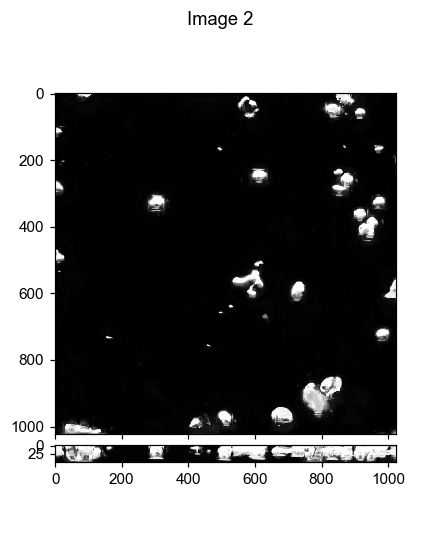

In [86]:
visual_tools.imshow_mark_3d_v2(flows3d[0].transpose(3,0,1,2))

In [101]:
blur = ndimage.gaussian_filter(test_dapi_im, 50)

In [102]:
from skimage import exposure

In [103]:
def scale_image(img, saturation_percentile=99.9):
    return np.minimum(img, np.percentile(img, saturation_percentile))

In [104]:
scale_dapi = scale_image(test_dapi_im)

<IPython.core.display.Javascript object>


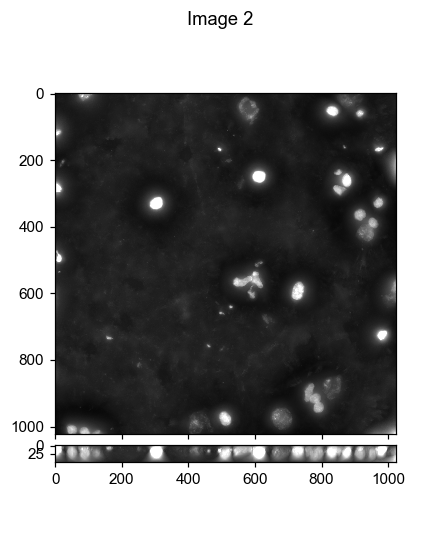

In [105]:
visual_tools.imshow_mark_3d_v2([scale_dapi, test_dapi_im/blur])

In [106]:
denoise_dapi = test_dapi_im/blur

In [107]:
# Create model class
seg_model = models.CellposeModel(gpu=True, model_type='nuclei') # create model
# run cellpose
_seg_start = time.time()
print(f"- run cellpose segmentation", end=' ')
labels3d, flows3d, _ = seg_model.eval(
    denoise_dapi[:,:,:,np.newaxis], 
    batch_size=60, 
    anisotropy=pixel_sizes[0]/pixel_sizes[1]/2,
    cellprob_threshold=0,
    invert=False,
    channels=[0,0], 
    diameter=30, 
    min_size=100,
    do_3D=True,
    )
print(f"in {time.time()-_seg_start:.2f}s. ")

- run cellpose segmentation in 42.21s. 


<IPython.core.display.Javascript object>


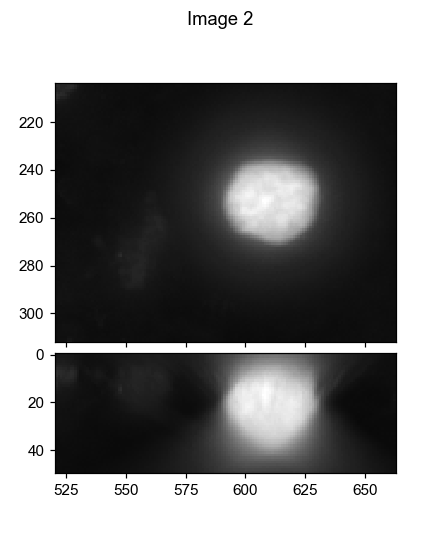

In [108]:
visual_tools.imshow_mark_3d_v2([test_dapi_im, denoise_dapi, labels3d, flows3d[0][:,:,:,0]] )

<IPython.core.display.Javascript object>


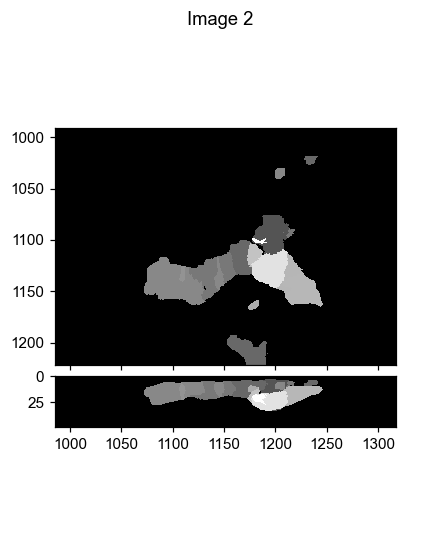

In [99]:
visual_tools.imshow_mark_3d_v2([dna_dapi, labels3d, flows3d[0][:,:,:,0]] )

In [62]:
test_labels = r'\\franklin\SSD_01\Pu_Temp\20220528-CTP07chr2_hSTG\Segmentation\Conv_zscan_070_Segmentation.npy'
test_labels = np.load(test_labels)

<IPython.core.display.Javascript object>


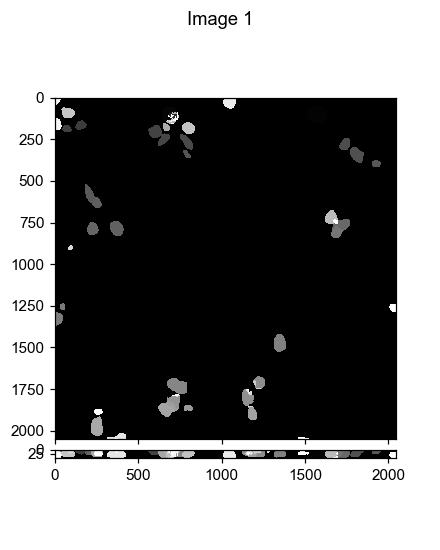

In [63]:
visual_tools.imshow_mark_3d_v2([test_labels])

<IPython.core.display.Javascript object>


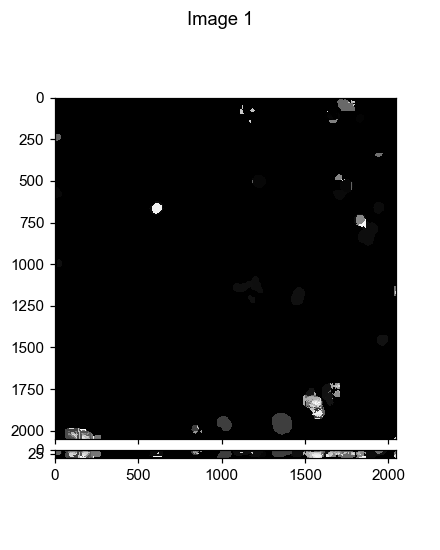

In [48]:
visual_tools.imshow_mark_3d_v2([labels3d, dna_dapi, final_labels])


In [17]:
import flowdec

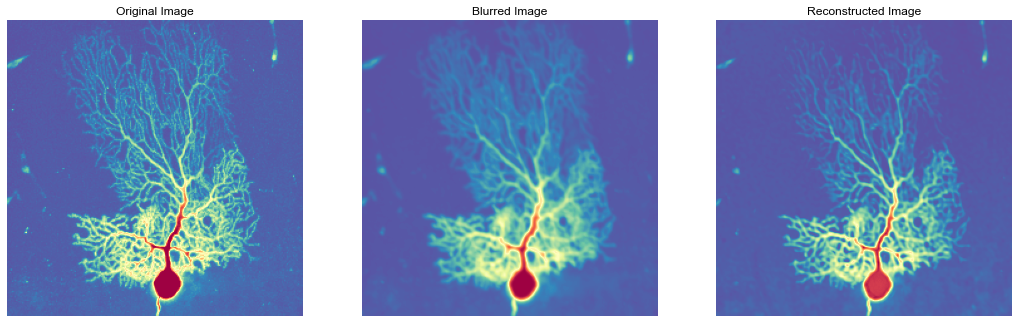

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from scipy import ndimage, signal
from flowdec import data as fd_data
from flowdec import restoration as fd_restoration

# Load "Purkinje Neuron" dataset downsampled from 200x1024x1024 to 50x256x256
# See: http://www.cellimagelibrary.org/images/CCDB_2
actual = fd_data.neuron_25pct().data
# actual.shape = (50, 256, 256)

# Create a gaussian kernel that will be used to blur the original acquisition
kernel = np.zeros_like(actual)
for offset in [0, 1]:
    kernel[tuple((np.array(kernel.shape) - offset) // 2)] = 1
kernel = ndimage.gaussian_filter(kernel, sigma=1.)
# kernel.shape = (50, 256, 256)

# Convolve the original image with our fake PSF
data = signal.fftconvolve(actual, kernel, mode='same')
# data.shape = (50, 256, 256)

# Run the deconvolution process and note that deconvolution initialization is best kept separate from 
# execution since the "initialize" operation corresponds to creating a TensorFlow graph, which is a 
# relatively expensive operation and should not be repeated across multiple executions
algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim).initialize()
res = algo.run(fd_data.Acquisition(data=data, kernel=kernel), niter=30).data

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()
fig.set_size_inches(18, 12)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Blurred Image', 'Reconstructed Image']
for i, d in enumerate([actual, data, res]):
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

In [20]:
#dna_dapi
algo = fd_restoration.RichardsonLucyDeconvolver(dna_dapi.ndim).initialize()
res = algo.run(fd_dna_dapi.Acquisition(dna_dapi=dna_dapi, kernel=kernel), niter=30).dna_dapi


NameError: name 'fd_dna_dapi' is not defined